## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
import zipfile
import os
import json
import wandb
from typing import Tuple, Optional, Dict, Any, List
import logging
from pathlib import Path
import random
from PIL import Image
import torchvision.transforms.functional as TF

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Creating class PolygonColorDataset

In [3]:
class PolygonColorDataset(Dataset):
    def __init__(self, data_dir: str, data_file: str = "data.json",
                 transform: Optional[transforms.Compose] = None,
                 augment: bool = False):
        self.data_dir = Path(data_dir)
        self.input_dir = self.data_dir / "inputs"
        self.output_dir = self.data_dir / "outputs"
        self.transform = transform
        self.augment = augment

        data_path = self.data_dir / data_file
        if not data_path.exists():
            raise FileNotFoundError(f"Data file not found: {data_path}")

        with open(data_path, "r") as f:
            entries = json.load(f)

        self.samples = [(d["input_polygon"], d["colour"], d["output_image"]) for d in entries]

        self.color_map = {
            "red": 0,
            "green": 1,
            "blue": 2,
            "yellow": 3,
            "purple": 4,
            "orange": 5,
            "cyan": 6,
            "magenta": 7
        }

        self.idx_to_color = {v: k for k, v in self.color_map.items()}

        logger.info(f"Loaded {len(self.samples)} samples from {data_dir}")
        logger.info(f"Available colors: {list(self.color_map.keys())}")

    def __len__(self) -> int:
        return len(self.samples)

    def _apply_augmentation(self, input_img: torch.Tensor, output_img: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if random.random() > 0.5:
            angle = random.uniform(-30, 30)
            input_img = TF.rotate(input_img, angle)
            output_img = TF.rotate(output_img, angle)

        if random.random() > 0.5:
            input_img = TF.hflip(input_img)
            output_img = TF.hflip(output_img)

        if random.random() > 0.5:
            input_img = TF.vflip(input_img)
            output_img = TF.vflip(output_img)

        return input_img, output_img

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        input_image_name, color_name, output_image_name = self.samples[idx]

        input_image_path = self.input_dir / input_image_name
        output_image_path = self.output_dir / output_image_name

        if not input_image_path.exists():
            raise FileNotFoundError(f"Input image not found: {input_image_path}")
        if not output_image_path.exists():
            raise FileNotFoundError(f"Output image not found: {output_image_path}")

        input_image = read_image(str(input_image_path)).float() / 255.0
        output_image = read_image(str(output_image_path)).float() / 255.0

        if input_image.shape[0] == 3:
            input_image = input_image.mean(dim=0, keepdim=True)

        if self.augment:
            input_image, output_image = self._apply_augmentation(input_image, output_image)

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        if color_name not in self.color_map:
            raise ValueError(f"Unknown color: {color_name}")

        color_idx = self.color_map[color_name]
        color_tensor = torch.tensor(color_idx, dtype=torch.long)

        return input_image, color_tensor, output_image


## Double Convolution Class

In [4]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, dropout: float = 0.0):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)


## Class Down

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, dropout: float = 0.0):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, bilinear: bool = True, dropout: float = 0.0):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, dropout)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, dropout)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


## Class ConditionalUNet

In [7]:
class ConditionalUNet(nn.Module):
    def __init__(self, num_classes: int = 8, embedding_dim: int = 64,
                 bilinear: bool = False, dropout: float = 0.1):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.bilinear = bilinear

        self.color_embedding = nn.Embedding(num_classes, embedding_dim)

        self.inc = DoubleConv(1 + embedding_dim, 64)
        self.down1 = Down(64, 128, dropout)
        self.down2 = Down(128, 256, dropout)
        self.down3 = Down(256, 512, dropout)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor, dropout)

        self.up1 = Up(1024, 512 // factor, bilinear, dropout)
        self.up2 = Up(512, 256 // factor, bilinear, dropout)
        self.up3 = Up(256, 128 // factor, bilinear, dropout)
        self.up4 = Up(128, 64, bilinear, dropout)

        self.outc = nn.Conv2d(64, 3, kernel_size=1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, 0, 0.1)

    def forward(self, x: torch.Tensor, color_idx: torch.Tensor) -> torch.Tensor:
        color_emb = self.color_embedding(color_idx)

        batch_size, _, height, width = x.shape
        color_map = color_emb.view(batch_size, self.embedding_dim, 1, 1)
        color_map = color_map.expand(-1, -1, height, width)

        x_conditioned = torch.cat([x, color_map], dim=1)

        x1 = self.inc(x_conditioned)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        output = torch.sigmoid(self.outc(x))

        return output

## Code for training the model

In [8]:
class PolygonColorizerTrainer:
    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"Using device: {self.device}")

        self.model = ConditionalUNet(
            num_classes=config['num_classes'],
            embedding_dim=config['embedding_dim'],
            bilinear=config['bilinear'],
            dropout=config['dropout']
        ).to(self.device)

        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        logger.info(f"Total parameters: {total_params:,}")
        logger.info(f"Trainable parameters: {trainable_params:,}")

        if config['optimizer'] == 'adam':
            self.optimizer = optim.Adam(
                self.model.parameters(),
                lr=config['learning_rate'],
                weight_decay=config['weight_decay'],
                betas=(0.9, 0.999)
            )
        elif config['optimizer'] == 'adamw':
            self.optimizer = optim.AdamW(
                self.model.parameters(),
                lr=config['learning_rate'],
                weight_decay=config['weight_decay']
            )

        if config['scheduler'] == 'reduce_lr_on_plateau':
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                patience=config['scheduler_patience'],
                factor=config['scheduler_factor'],
                verbose=True
            )
        elif config['scheduler'] == 'cosine_annealing':
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer,
                T_max=config['num_epochs']
            )

        self.criterion_l1 = nn.L1Loss()
        self.criterion_mse = nn.MSELoss()

        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []

        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def compute_loss(self, predicted: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        l1_loss = self.criterion_l1(predicted, target)
        mse_loss = self.criterion_mse(predicted, target)

        total_loss = (
            self.config['l1_weight'] * l1_loss +
            self.config['mse_weight'] * mse_loss
        )

        return total_loss, l1_loss, mse_loss

    def train_epoch(self, train_loader: DataLoader, epoch: int) -> Dict[str, float]:
        self.model.train()
        total_loss = 0.0
        total_l1_loss = 0.0
        total_mse_loss = 0.0

        for batch_idx, (input_img, color_idx, target_img) in enumerate(train_loader):
            input_img = input_img.to(self.device)
            color_idx = color_idx.to(self.device)
            target_img = target_img.to(self.device)

            predicted_img = self.model(input_img, color_idx)
            loss, l1_loss, mse_loss = self.compute_loss(predicted_img, target_img)

            self.optimizer.zero_grad()
            loss.backward()

            if self.config.get('grad_clip_max_norm'):
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    max_norm=self.config['grad_clip_max_norm']
                )

            self.optimizer.step()

            total_loss += loss.item()
            total_l1_loss += l1_loss.item()
            total_mse_loss += mse_loss.item()

            if batch_idx % self.config['log_interval'] == 0:
                logger.info(
                    f"Epoch {epoch+1}/{self.config['num_epochs']}, "
                    f"Batch {batch_idx}/{len(train_loader)}, "
                    f"Loss: {loss.item():.4f}"
                )

        avg_loss = total_loss / len(train_loader)
        avg_l1_loss = total_l1_loss / len(train_loader)
        avg_mse_loss = total_mse_loss / len(train_loader)

        return {
            'train_loss': avg_loss,
            'train_l1_loss': avg_l1_loss,
            'train_mse_loss': avg_mse_loss
        }

    def validate(self, val_loader: DataLoader) -> Dict[str, float]:

        self.model.eval()
        total_loss = 0.0
        total_l1_loss = 0.0
        total_mse_loss = 0.0

        with torch.no_grad():
            for input_img, color_idx, target_img in val_loader:
                input_img = input_img.to(self.device)
                color_idx = color_idx.to(self.device)
                target_img = target_img.to(self.device)

                predicted_img = self.model(input_img, color_idx)
                loss, l1_loss, mse_loss = self.compute_loss(predicted_img, target_img)

                total_loss += loss.item()
                total_l1_loss += l1_loss.item()
                total_mse_loss += mse_loss.item()

        avg_loss = total_loss / len(val_loader)
        avg_l1_loss = total_l1_loss / len(val_loader)
        avg_mse_loss = total_mse_loss / len(val_loader)

        return {
            'val_loss': avg_loss,
            'val_l1_loss': avg_l1_loss,
            'val_mse_loss': avg_mse_loss
        }

    def train(self, train_loader: DataLoader, val_loader: DataLoader):
        logger.info("Starting training...")

        for epoch in range(self.config['num_epochs']):
            train_metrics = self.train_epoch(train_loader, epoch)

            val_metrics = self.validate(val_loader)

            if self.config['scheduler'] == 'reduce_lr_on_plateau':
                self.scheduler.step(val_metrics['val_loss'])
            elif self.config['scheduler'] == 'cosine_annealing':
                self.scheduler.step()

            current_lr = self.optimizer.param_groups[0]['lr']
            self.train_losses.append(train_metrics['train_loss'])
            self.val_losses.append(val_metrics['val_loss'])
            self.learning_rates.append(current_lr)

            logger.info(
                f"Epoch {epoch+1}/{self.config['num_epochs']} - "
                f"Train Loss: {train_metrics['train_loss']:.4f}, "
                f"Val Loss: {val_metrics['val_loss']:.4f}, "
                f"LR: {current_lr:.6f}"
            )

            if self.config.get('use_wandb', False):
                wandb.log({
                    "epoch": epoch + 1,
                    "learning_rate": current_lr,
                    **train_metrics,
                    **val_metrics
                })

            if val_metrics['val_loss'] < self.best_val_loss:
                self.best_val_loss = val_metrics['val_loss']
                self.patience_counter = 0
                self.save_model("best_model.pth", epoch, val_metrics['val_loss'])
                logger.info(f"New best model saved! Val Loss: {val_metrics['val_loss']:.4f}")
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.config['early_stopping_patience']:
                logger.info(f"Early stopping triggered after {epoch + 1} epochs")
                break

            if (epoch + 1) % self.config.get('checkpoint_interval', 10) == 0:
                self.save_model(f"checkpoint_epoch_{epoch+1}.pth", epoch, val_metrics['val_loss'])

        logger.info("Training completed!")

    def save_model(self, filepath: str, epoch: int, val_loss: float):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict() if self.scheduler else None,
            'val_loss': val_loss,
            'config': self.config,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }

        torch.save(checkpoint, filepath)
        logger.info(f"Model checkpoint saved: {filepath}")

    def load_model(self, filepath: str):
        checkpoint = torch.load(filepath, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        if checkpoint.get('scheduler_state_dict') and self.scheduler:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])

        logger.info(f"Model loaded from {filepath}")
        logger.info(f"Epoch: {checkpoint['epoch']}, Val Loss: {checkpoint['val_loss']:.4f}")

        return checkpoint

    def plot_training_history(self, save_path: str = "training_history.png"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        if self.learning_rates:
            ax2.plot(epochs, self.learning_rates, 'g-', linewidth=2)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_title('Learning Rate Schedule')
            ax2.set_yscale('log')
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

        logger.info(f"Training history plot saved: {save_path}")


## Creating DataLoaders

In [9]:
def create_data_loaders(config: Dict[str, Any]) -> Tuple[DataLoader, DataLoader]:

    base_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size']))
    ])

    train_dataset = PolygonColorDataset(
        data_dir=config['train_data_dir'],
        data_file="data.json",
        transform=base_transform,
        augment=config['use_augmentation']
    )

    val_dataset = PolygonColorDataset(
        data_dir=config['val_data_dir'],
        data_file="data.json",
        transform=base_transform,
        augment=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['val_batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )

    logger.info(f"Training samples: {len(train_dataset)}")
    logger.info(f"Validation samples: {len(val_dataset)}")

    return train_loader, val_loader, train_dataset, val_dataset


## Function for tracking the Experiments

In [10]:
def setup_experiment_tracking(config: Dict[str, Any]):

    if config.get('use_wandb', False):
        wandb.init(
            project=config['wandb_project'],
            name=config.get('experiment_name'),
            config=config,
            tags=config.get('wandb_tags', [])
        )

        logger.info("Wandb initialized successfully")
    else:
        logger.info("Wandb tracking disabled")

## Calling the Train Function

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: soumitsaha03 (soumitsaha03-indian-institute-of-technology-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


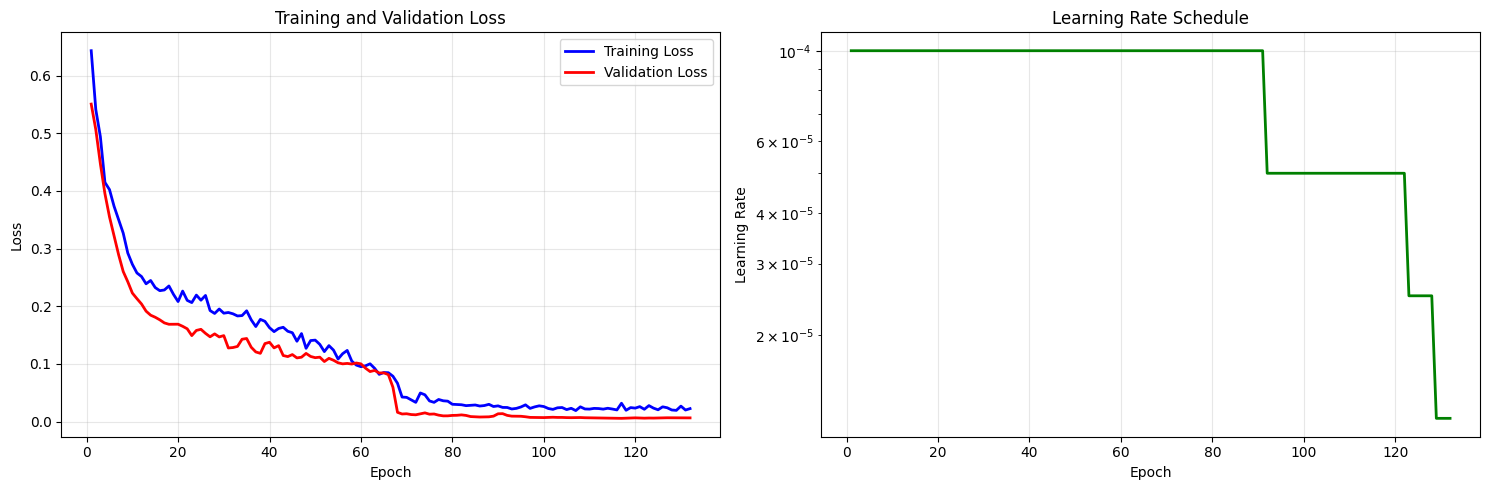

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
learning_rate,████████████████████████▄▄▄▄▄▄▄▄▄▄▄▂▂▂▁▁
train_l1_loss,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▅▄▄▅▄▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_l1_loss,█▅▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▅▅▄▄▄▄▄▄▃▄▄▃▃▄▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,132
learning_rate,1e-05
train_l1_loss,0.02019


In [11]:
def main():
    set_seed(42)

    config = {
        'train_data_dir': "/content/Extracted_datasets/dataset/training",
        'val_data_dir': "/content/Extracted_datasets/dataset/validation",
        'image_size': 256,
        'use_augmentation': True,
        'num_workers': 2,

        'num_classes': 8,
        'embedding_dim': 64,
        'bilinear': False,
        'dropout': 0.1,

        'batch_size': 16,
        'val_batch_size': 8,
        'num_epochs': 200,
        'learning_rate': 1e-4,
        'weight_decay': 1e-5,
        'optimizer': 'adam',

        'l1_weight': 1.0,
        'mse_weight': 0.5,

        'scheduler': 'reduce_lr_on_plateau',
        'scheduler_patience': 5,
        'scheduler_factor': 0.5,

        'grad_clip_max_norm': 1.0,

        'early_stopping_patience': 15,
        'checkpoint_interval': 10,

        'log_interval': 10,

        'use_wandb': True,
        'wandb_project': "ayna-polygon-colorizer",
        'experiment_name': "conditional-unet-v1",
        'wandb_tags': ["unet", "conditional", "polygon", "colorization"]
    }

    try:
        setup_experiment_tracking(config)

        dataset_zip_path = "/content/dataset.zip"
        extract_path = "/content/Extracted_datasets"

        if os.path.exists(dataset_zip_path) and not os.path.exists(extract_path):
            logger.info("Extracting dataset...")
            with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            logger.info("Dataset extracted successfully")

        train_loader, val_loader, train_dataset, val_dataset = create_data_loaders(config)

        trainer = PolygonColorizerTrainer(config)

        if config.get('use_wandb', False):
            wandb.watch(trainer.model, log="all", log_freq=100)

        trainer.train(train_loader, val_loader)

        trainer.plot_training_history()
        trainer.save_model("final_model.pth", config['num_epochs'], trainer.best_val_loss)

        logger.info("Training completed successfully!")

    except Exception as e:
        logger.error(f"Training failed with error: {e}")
        raise

    finally:
        if config.get('use_wandb', False):
            wandb.finish()

if __name__ == "__main__":
    main()

## Inference class code

In [12]:
class PolygonColorizerInference:
    def __init__(self, model_path: str, device: str = 'auto'):
        self.device = self._setup_device(device)
        self.model = None
        self.config = None

        self.color_map = {
            "red": 0, "green": 1, "blue": 2, "yellow": 3,
            "purple": 4, "orange": 5, "cyan": 6, "magenta": 7
        }
        self.idx_to_color = {v: k for k, v in self.color_map.items()}

        self.load_model(model_path)

        self.transform = transforms.Compose([
            transforms.Resize((256, 256))
        ])

    def _setup_device(self, device: str):
        if device == 'auto':
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

        device = torch.device(device)
        print(f"Using device: {device}")
        return device

    def load_model(self, model_path: str):
        print(f"Loading model from: {model_path}")

        checkpoint = torch.load(model_path, map_location=self.device)
        self.config = checkpoint.get('config', {})

        self.model = ConditionalUNet(
            num_classes=self.config.get('num_classes', 8),
            embedding_dim=self.config.get('embedding_dim', 64),
            bilinear=self.config.get('bilinear', False),
            dropout=0.0
        ).to(self.device)


        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        print("Model loaded successfully!")
        print(f"Model was trained for {checkpoint.get('epoch', 'unknown')} epochs")
        print(f"Best validation loss: {checkpoint.get('val_loss', 'unknown'):.4f}")

    def preprocess_image(self, image_path: str):
        image = read_image(image_path).float() / 255.0

        if image.shape[0] == 3:
            image = image.mean(dim=0, keepdim=True)

        image = self.transform(image)

        image = image.unsqueeze(0)

        return image

    def predict(self, image_path: str, color_name: str):
        if color_name not in self.color_map:
            raise ValueError(f"Unknown color: {color_name}. Available colors: {list(self.color_map.keys())}")

        input_tensor = self.preprocess_image(image_path).to(self.device)
        color_idx = torch.tensor([self.color_map[color_name]], dtype=torch.long).to(self.device)

        with torch.no_grad():
            predicted_tensor = self.model(input_tensor, color_idx)

        input_np = input_tensor.squeeze().cpu().numpy()
        predicted_np = predicted_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
        predicted_np = np.clip(predicted_np, 0, 1)

        return input_np, predicted_np

    def visualize_prediction(self, image_path: str, color_name: str, save_path: str = None):
        input_np, predicted_np = self.predict(image_path, color_name)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].imshow(input_np, cmap='gray')
        axes[0].set_title('Input Polygon', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(predicted_np)
        axes[1].set_title(f'Predicted - {color_name.capitalize()}', fontsize=14, fontweight='bold')
        axes[1].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")

        plt.show()

    def compare_with_ground_truth(self, validation_data_dir: str, sample_indices: list = [0, 1, 2]):

        data_file = Path(validation_data_dir) / "data.json"
        with open(data_file, 'r') as f:
            validation_samples = json.load(f)

        input_dir = Path(validation_data_dir) / "inputs"
        output_dir = Path(validation_data_dir) / "outputs"

        fig, axes = plt.subplots(len(sample_indices), 3, figsize=(15, 5*len(sample_indices)))
        if len(sample_indices) == 1:
            axes = axes.reshape(1, -1)

        for i, idx in enumerate(sample_indices):
            sample = validation_samples[idx]
            input_path = input_dir / sample["input_polygon"]
            output_path = output_dir / sample["output_image"]
            color_name = sample["colour"]

            input_np, predicted_np = self.predict(str(input_path), color_name)


            ground_truth = read_image(str(output_path)).float() / 255.0
            ground_truth = self.transform(ground_truth).permute(1, 2, 0).numpy()

            axes[i, 0].imshow(input_np, cmap='gray')
            axes[i, 0].set_title(f'Input - {color_name}', fontsize=12)
            axes[i, 0].axis('off')

            axes[i, 1].imshow(ground_truth)
            axes[i, 1].set_title('Ground Truth', fontsize=12)
            axes[i, 1].axis('off')

            axes[i, 2].imshow(predicted_np)
            axes[i, 2].set_title('Model Prediction', fontsize=12)
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()

    def get_model_info(self):
        print("=== Model Information ===")
        print(f"Model Architecture: Conditional UNet")
        print(f"Number of Parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Trainable Parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad):,}")
        print()

        print("=== Configuration ===")
        if self.config:
            for key, value in self.config.items():
                print(f"{key}: {value}")
        else:
            print("Configuration not available")
        print()

        print("=== Available Colors ===")
        for color_name in self.color_map.keys():
            print(f"- {color_name}")



In [13]:
def inference():
    print("=== Ayna ML Assignment - Polygon Colorizer Demo ===")
    print()

    model_path = "best_model.pth"
    colorizer = PolygonColorizerInference(model_path)

    colorizer.get_model_info()

    print("Single Color Prediction")
    validation_dir = "/content/Extracted_datasets/dataset/validation"

    with open(f"{validation_dir}/data.json", 'r') as f:
        samples = json.load(f)

    sample = samples[0]
    n = len(samples)
    input_path = f"{validation_dir}/inputs/{sample['input_polygon']}"

    original_color = sample['colour']

    print(f"Input: {sample['input_polygon']}")
    print(f"Testing with color: {original_color}")

    colorizer.visualize_prediction(input_path, original_color, "single_prediction_demo.png")

    print("Comparison with Ground Truth")
    colorizer.compare_with_ground_truth(validation_dir, [i for i in range(n)])

=== Ayna ML Assignment - Polygon Colorizer Demo ===

Using device: cuda
Loading model from: best_model.pth
Model loaded successfully!
Model was trained for 116 epochs
Best validation loss: 0.0055
=== Model Information ===
Model Architecture: Conditional UNet
Number of Parameters: 31,073,987
Trainable Parameters: 31,073,987

=== Configuration ===
train_data_dir: /content/Extracted_datasets/dataset/training
val_data_dir: /content/Extracted_datasets/dataset/validation
image_size: 256
use_augmentation: True
num_workers: 2
num_classes: 8
embedding_dim: 64
bilinear: False
dropout: 0.1
batch_size: 16
val_batch_size: 8
num_epochs: 200
learning_rate: 0.0001
weight_decay: 1e-05
optimizer: adam
l1_weight: 1.0
mse_weight: 0.5
scheduler: reduce_lr_on_plateau
scheduler_patience: 5
scheduler_factor: 0.5
grad_clip_max_norm: 1.0
early_stopping_patience: 15
checkpoint_interval: 10
log_interval: 10
use_wandb: True
wandb_project: ayna-polygon-colorizer
experiment_name: conditional-unet-v1
wandb_tags: ['un

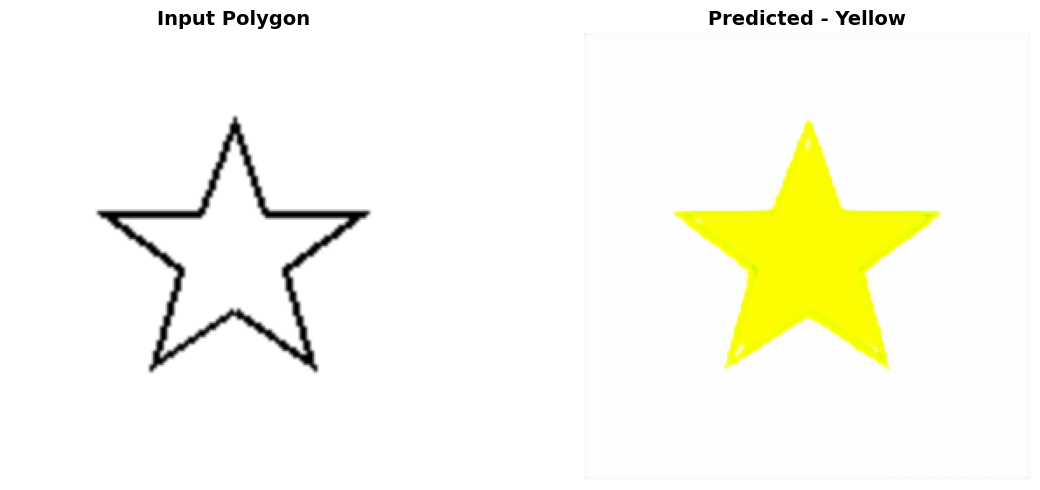

Comparison with Ground Truth


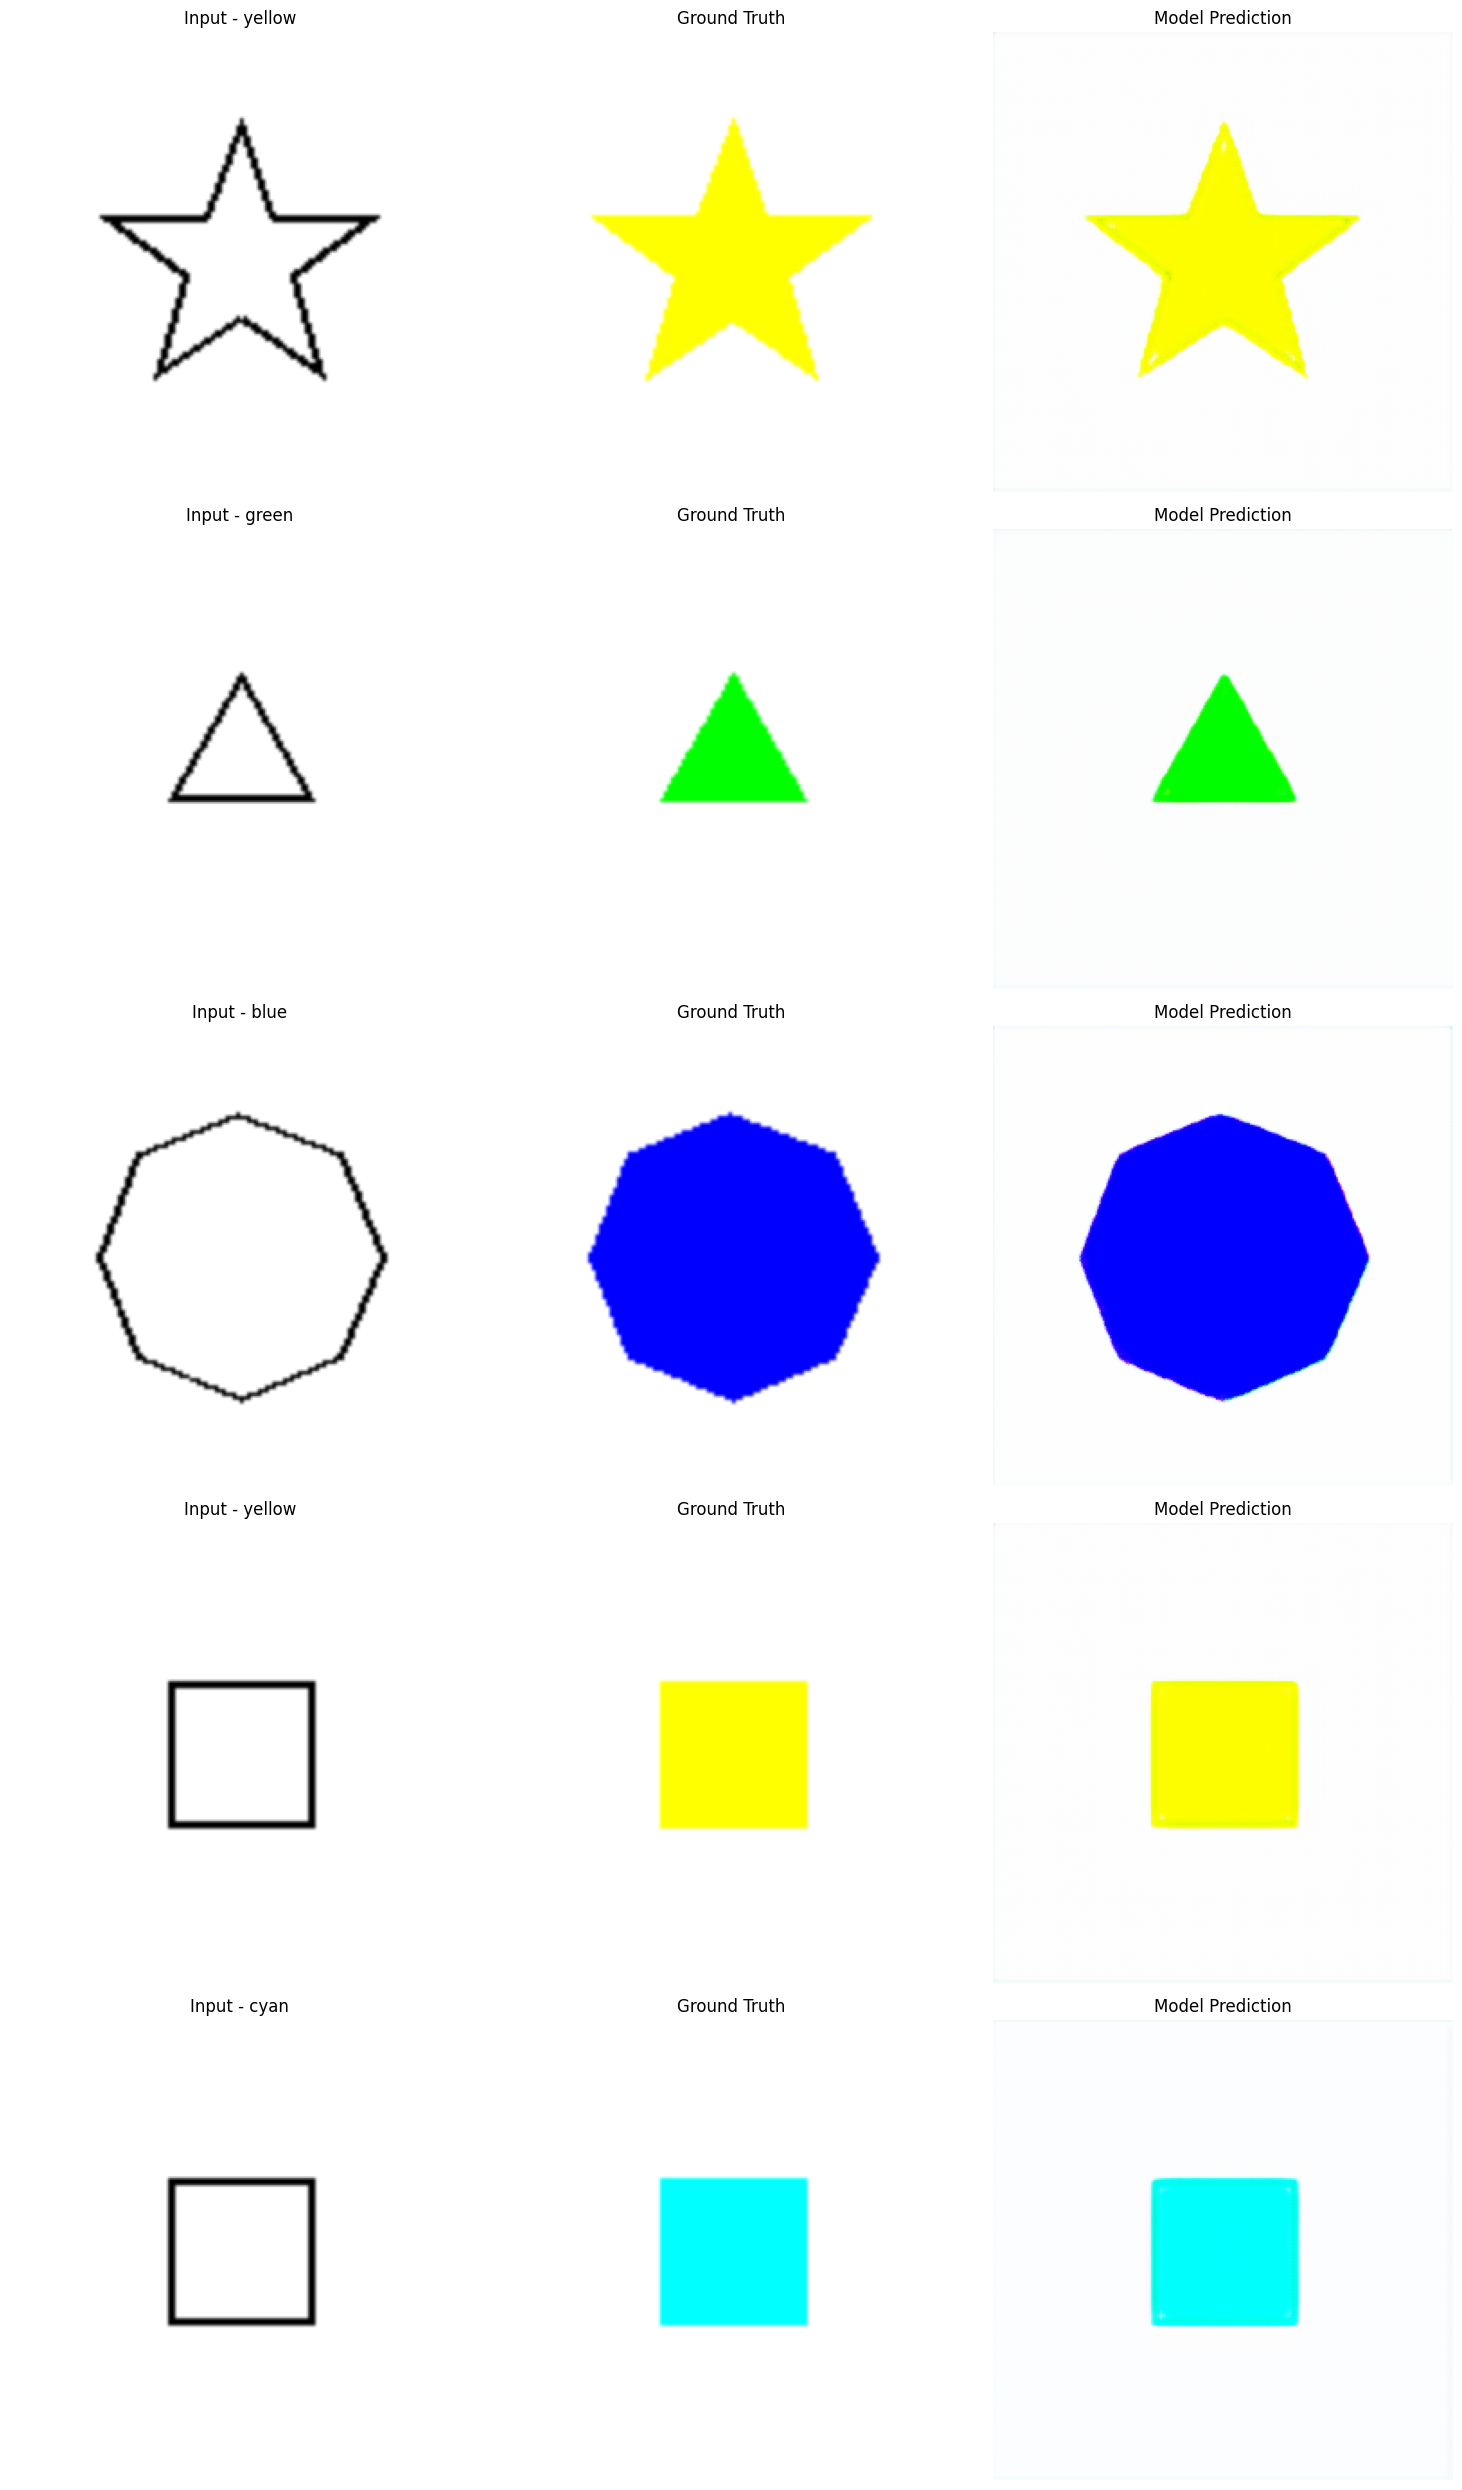

In [14]:
if __name__ == "__main__":
    inference()